We need to evaluate features we can try and improve and restore for photos, this includes - 
    - Blurriness
    - Blemishes
    - Colour Faded/Low Saturations, etc

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Sharpening Photos 

In [ ]:
photo = cv2.imread('sample-photos/old_photo_01.jpg')

k = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]],dtype=float)
k = k / k.sum()
sharp = cv2.filter2D(photo, -1, k)

cv2.imshow('Original Image', photo)
cv2.imshow('Sharp Photo', sharp)

key = cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

Increasing brightness if brightness is below a certain threshold

In [ ]:
grey = cv2.cvtColor(sharp, cv2.COLOR_BGR2GRAY)

brightness = np.mean(grey) #mean to get brightness
brightened = sharp

# if image has low brightness
if brightness < 100:
    gamma = 1.5
    brightened = np.power(sharp / 255.0, 1 / gamma)
    brightened = np.uint8(brightened * 255)

# showing all for testing purposes
cv2.imshow('Original Image', photo)
cv2.imshow('Sharp Photo', sharp)
cv2.imshow('Brightened Image', brightened)
key = cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

MASKING AND INPAINT 

In [ ]:
def show_image(title, img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

In [ ]:
#function to check if the image has scratches or damages that need inpainting
def needs_masking(photo):
    #convert to greyscale 
    grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY) 
    #create mask of pixels with brightness in between 110 and 160
    mask_mid = cv2.inRange(grey, 110, 160) 

    #calculate if mask contains damage
    damage_ratio = np.count_nonzero(mask_mid) / mask_mid.size
    
    #if more than 1% damage return true 
    return damage_ratio > 0.01   

In [ ]:
#function to generate a mask and repaint those areas 
def masking(photo):
    #convert to greyscale
    grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    #select mid-intensity pixels where scratches appear
    mask_mid = cv2.inRange(grey, 110, 160) 
    #create a kernel for morphological filtering
    kernel = np.ones((5,5), np.uint8)
    
    #opening to remove small isolated noise 
    mask_mid = cv2.morphologyEx(mask_mid, cv2.MORPH_OPEN, kernel)
    #closing to fill tiny hiles detected 
    mask_mid = cv2.morphologyEx(mask_mid, cv2.MORPH_CLOSE, kernel)

    #another opening to remove bigger spots(reduce false positives)
    mask_small = cv2.morphologyEx(mask_mid, cv2.MORPH_OPEN, np.ones((9,9), np.uint8))
    #conevet into binary mask
    _, damage_mask = cv2.threshold(mask_small, 127, 255, cv2.THRESH_BINARY)

    #use inpaint to fill in the damaged areas 
    restored = cv2.inpaint(photo, damage_mask, 5, cv2.INPAINT_TELEA)

    return damage_mask, restored
show_image("Original Photo", photo)
show_image("inpaint", masking(photo)[1])


gaussian

In [ ]:
#function to check if the images are noisy enough to need gaussian blur
def needs_gaussian(grey, threshold=300): 
    #apply laplacian  to highlight edges and noise 
    lap = cv2.Laplacian(grey, cv2.CV_64F)
    #calcuate variance of the laplacian  
    noise_level = lap.var() 
    
    #if noise is abouve threshold return true 
    return noise_level > threshold

In [ ]:
#function to apply the gaussian blur
def gaussian(photo, ksize=3, sigma=0.5): 
    return cv2.GaussianBlur(photo, (ksize, ksize), sigma) 

show_image("Original Photo", photo) 
show_image("Gaussian Blurred", gaussian(photo))

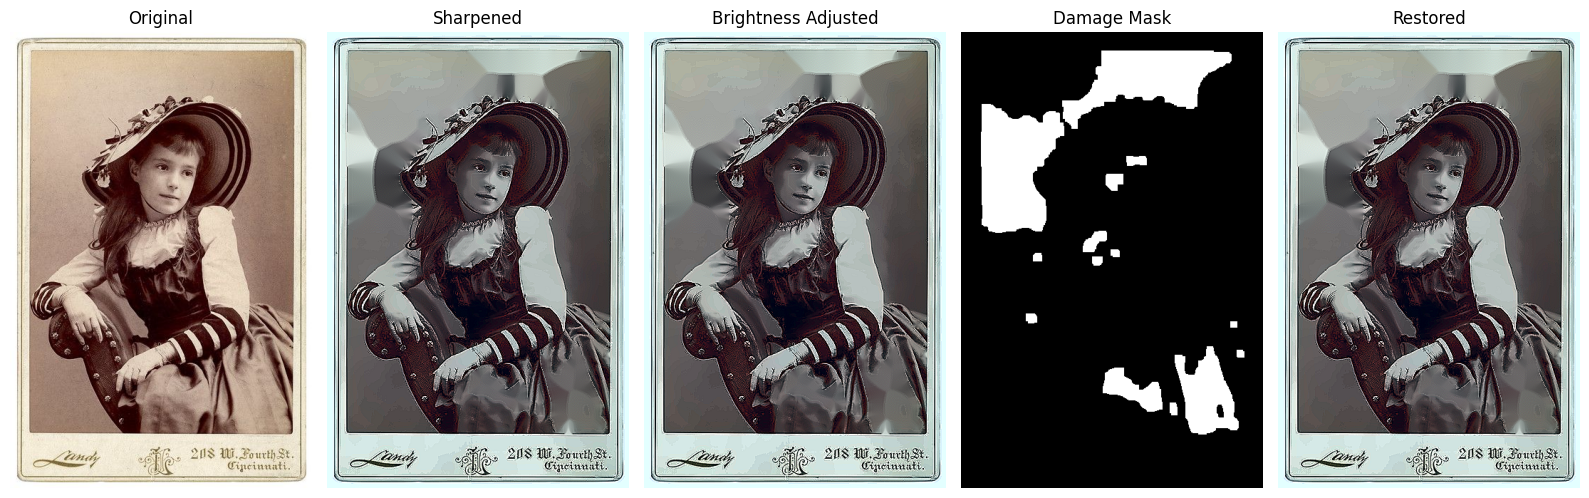

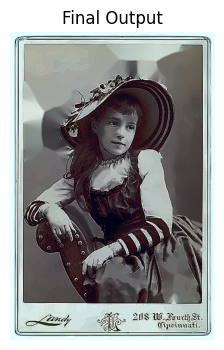

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, img_bgr):
    if img_bgr is None:
        print(f"{title}: image is None")
        return

    if len(img_bgr.shape) == 2:
        img_rgb = img_bgr
        cmap = "gray"
    else:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        cmap = None

    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.imshow(img_rgb, cmap=cmap)
    plt.axis('off')
    plt.show()


def show_results(original, sharp, brightened, damage_mask, restored):
    plt.figure(figsize=(16, 5))

    titles = ["Original", "Sharpened", "Brightness Adjusted",
              "Damage Mask", "Restored"]
    images = [original, sharp, brightened, damage_mask, restored]

    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, 5, i)

        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def sharpen_image(photo):
    k = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]], dtype=float)
    k = k / k.sum()
    sharp = cv2.filter2D(photo, -1, k)
    return sharp


def adjust_brightness(photo, grey, threshold=100, gamma=0.5):
    brightness = np.mean(grey)

    if brightness < threshold:
        corrected = np.power(photo / 255.0, gamma)
        corrected = np.uint8(corrected * 255)
        return corrected
    
    return photo


def colour_correction(photo):

    photo_lab = cv2.cvtColor(photo, cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(photo_lab)

    a_corrected = a - (np.mean(a) - 128)
    b_corrected = b - (np.mean(b) - 128)

    a_corrected = np.clip(a_corrected, 0, 255).astype(np.uint8)
    b_corrected = np.clip(b_corrected, 0, 255).astype(np.uint8)

    L_eq = cv2.equalizeHist(l)

    lab_corrected = cv2.merge((L_eq, a_corrected, b_corrected))
    final_img = cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2BGR)

    return final_img


def denoise_image(photo):
    denoised_img = cv2.fastNlMeansDenoisingColored(photo, None, 5, 5, 7, 21)
    return denoised_img


def needs_gaussian(grey, threshold=300):
    lap = cv2.Laplacian(grey, cv2.CV_64F)
    noise_level = lap.var()
    return noise_level > threshold


def needs_inpainting(grey):
    mask_mid = cv2.inRange(grey, 110, 160)
    damage_ratio = np.count_nonzero(mask_mid) / mask_mid.size
    return damage_ratio > 0.01   


def gaussian(photo, ksize=3, sigma=0.5):
    return cv2.GaussianBlur(photo, (ksize, ksize), sigma)


def inpainting(photo):
    grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    
    mask_mid = cv2.inRange(grey, 110, 160)

    kernel = np.ones((5,5), np.uint8)
    mask_mid = cv2.morphologyEx(mask_mid, cv2.MORPH_OPEN, kernel) 
    mask_mid = cv2.morphologyEx(mask_mid, cv2.MORPH_CLOSE, kernel)

    mask_small = cv2.morphologyEx(mask_mid, cv2.MORPH_OPEN,
                                  np.ones((9,9), np.uint8))

    _, damage_mask = cv2.threshold(mask_small, 127, 255, cv2.THRESH_BINARY)

    restored = cv2.inpaint(photo, damage_mask, 5, cv2.INPAINT_TELEA)

    return damage_mask, restored


def features_from_image(photo):
    gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 80, 160)

    _, th = cv2.threshold(gray, 0, 255,
                          cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    contour_mask = np.zeros_like(gray)
    for c in contours:
        if 20 < cv2.arcLength(c, True) < 300:
            cv2.drawContours(contour_mask, [c], -1, 255, -1)

    combined_mask = cv2.bitwise_or(edges, contour_mask)
    restored = cv2.inpaint(photo, combined_mask, 3, cv2.INPAINT_TELEA)

    return combined_mask, restored

 
def restore_photo(photo):
    output = photo.copy()

    output = denoise_image(output)
    
    output = colour_correction(output)
    
    grey = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
    output = adjust_brightness(output, grey)

    grey = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
    if needs_gaussian(grey):
        output = gaussian(output)

    grey = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
    if needs_inpainting(grey):
        damage_mask, output = inpainting(output)
    else:
        damage_mask = np.zeros(output.shape[:2], np.uint8)

    output = sharpen_image(output)

    return damage_mask, output


photo = cv2.imread('sample-photos/old_photo_28.jpg')

damage_mask, final_output = restore_photo(photo)

show_results(photo, final_output, final_output, damage_mask, final_output)
show_image("Final Output", final_output)
